In [364]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [365]:
import numpy as np
from stable_baselines3 import DDPG
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

from src.environment.components.adaptive_consumption import AdaptiveConsumptionParameters
from src.environment.components.battery import BatteryParameters
from src.environment.components.tcl import TCLParameters
from visualization import visualize_battery_behaviour, visualize_scenario, visualize_reward

In [366]:
name = "ppo_battery_only_synthetic_10eps"
parameter = {
    "env/parameters/adaptive_consumption": False,
    "env/parameters/battery": True,
    "env/parameters/tcl": False,
    "env/parameters/data": "synthetic",
    "env/parameters/episode_length": 100,
    "model/parameters/epochs": 10,
    "model/parameters/algorithm": "PPO",
}

In [367]:
from src.environment.single_family_home import SingleFamilyHome, LoggingCallback
env = Monitor(SingleFamilyHome(
    adaptive_consumption_params=AdaptiveConsumptionParameters() if parameter["env/parameters/adaptive_consumption"] else None,
    battery_params=BatteryParameters() if parameter["env/parameters/battery"] else None,
    tcl_params=TCLParameters() if parameter["env/parameters/tcl"] else None,
    synthetic_data=parameter["env/parameters/data"] == "synthetic",
    episode_length=parameter["env/parameters/episode_length"],
))

In [368]:
check_env(env, warn=True)

In [369]:
model = DDPG("MlpPolicy", env, tensorboard_log="./tensorboard/")

In [370]:
untrained_callback = LoggingCallback()
untrained_accumulated_reward, untrained_std_reward = evaluate_policy(model, env, n_eval_episodes=1, callback=untrained_callback)
untrained_accumulated_reward

-28.655437

In [371]:
train_callback = LoggingCallback()
model.learn(total_timesteps=len(env.unwrapped.electricity_grid.episode)*parameter["model/parameters/epochs"], callback=train_callback)

In [372]:
trained_callback = LoggingCallback()
trained_accumulated_reward, trained_std_reward = evaluate_policy(model, env, n_eval_episodes=1, callback=trained_callback)
trained_accumulated_reward

-15.592501

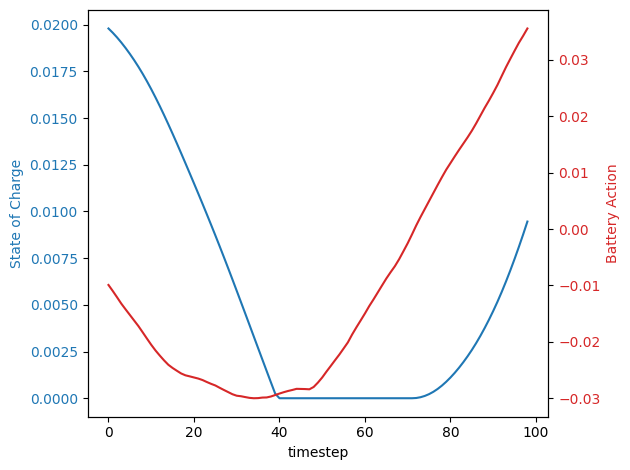

In [374]:
visualize_battery_behaviour(untrained_callback, env.unwrapped)

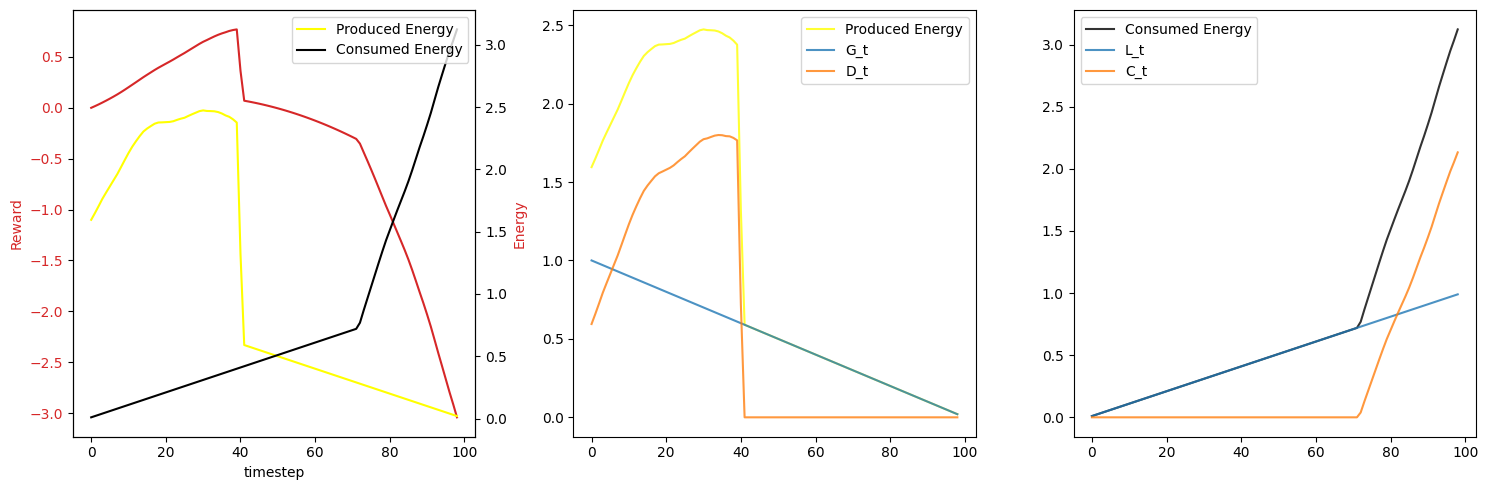

In [375]:
visualize_reward(untrained_callback)

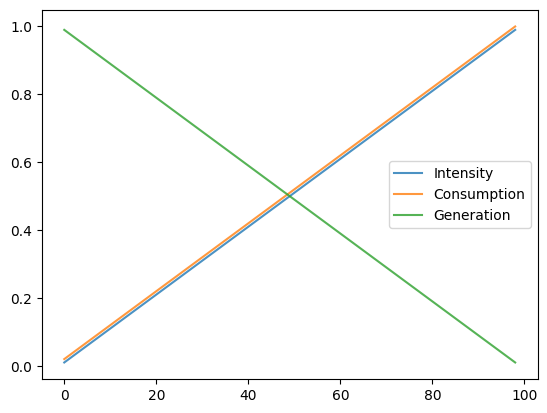

In [376]:
visualize_scenario(trained_callback, env.unwrapped)